In [12]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm

In [25]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

cuda:0


In [3]:
# img, label = train_data[0] 取下标返回一个(Tensor, label)元组

def calc_mean_std(data_set):
    mean = 0.
    std  = 0.

    # 计算每个图片的均值和标准差在累加的目的是：更准确的捕捉每张图片的特点，避免了数据集整体偏差对个别图像影响过大
    for img, label in data_set:
        mean += img.mean(dim=(1, 2))
        std  += img.std(dim=(1, 2))

    mean /= len(data_set)
    std  /= len(data_set)

    return mean, std

# print(calc_mean_std(train_data))


In [26]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader  = DataLoader(test_data,  batch_size=64, shuffle=True)

In [27]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )

    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

In [28]:
class SaveCheckpointCallback:
    def __init__(self, save_dir, save_step=500, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir # 保存路径
        self.save_step = save_step # 保存步数
        self.save_best_only = save_best_only # 是否只保存最好的模型
        self.best_metrics = -1 # 最好的指标，指标不可能为负数，所以初始化为-1
        
        # mkdir
        if not os.path.exists(self.save_dir): # 如果不存在保存路径，则创建
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0: #每隔save_step步保存一次
            return
        
        if self.save_best_only:
            assert metric is not None # 必须传入metric
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt")) # 保存最好的模型，覆盖之前的模型，不保存step，只保存state_dict，即模型参数，不保存优化器参数
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt")) # 保存每个step的模型，不覆盖之前的模型，保存step，保存state_dict，即模型参数，不保存优化器参数

In [29]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience # 多少个epoch没有提升就停止训练
        self.min_delta = min_delta # 最小的提升幅度
        self.best_metric = -1
        self.counter = 0
        
    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:#用准确率
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else: 
            self.counter += 1 # 计数器加1，下面的patience判断用到
            
    @property
    def early_stop(self):
        return self.counter >= self.patience


In [30]:
model = NeuralNetwork()

print(model)    # 查看网络结构
print('-' * 80)

for name, param in model.named_parameters():    # 查看形状
    print(name, param.shape)
print('-' * 80)

print(list(model.parameters())) # 查看模型参数

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)
--------------------------------------------------------------------------------
linear_relu_stack.0.weight torch.Size([300, 784])
linear_relu_stack.0.bias torch.Size([300])
linear_relu_stack.2.weight torch.Size([100, 300])
linear_relu_stack.2.bias torch.Size([100])
linear_relu_stack.4.weight torch.Size([10, 100])
linear_relu_stack.4.bias torch.Size([10])
--------------------------------------------------------------------------------
[Parameter containing:
tensor([[-0.0231,  0.0191,  0.0164,  ...,  0.0131, -0.0068, -0.0131],
        [ 0.0249,  0.0081, -0.0178,  ...,  0.0121,  0.0019, -0.0318],
        [ 0.0267, -0.0203, -0.0197,  ...,  0.0308, -0.0002, -0.0056],
        .

In [31]:
loss_function = nn.CrossEntropyLoss()   # 损失函数
optimizer_sgd = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # 优化器 随机梯度下降SGD

In [32]:
@torch.no_grad() # 装饰器 禁止反向传播 节省内存
def evaluating(model, data_loader, loss_function):
    loss_list  = [] # 记录损失
    pred_list  = [] # 记录预测
    label_list = [] # 记录标签

    for datas, labels in data_loader:
        datas  = datas.to(device)
        labels = labels.to(device)

        logits = model(datas)
        loss = loss_function(logits, labels)
        loss_list.append(loss.item())

        preds = logits.argmax(axis=-1)
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())
    
    acc = accuracy_score(label_list, pred_list)
    
    return np.mean(loss_list), acc

In [33]:
def plot_learning_curve(record_dict, sample_step=1000):
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    test_df = pd.DataFrame(record_dict["test"]).set_index("step")
    last_step = train_df.index[-1]

    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        # print(train_df[item].values)
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(test_df.index, test_df[item], label=f"test_{item}")
        axs[idx].grid() # 显示网格
        axs[idx].legend() # 显示图例
        axs[idx].set_xticks(range(0, train_df.index[-1], 5000)) # 设置x轴刻度
        axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, last_step, 5000))) # 设置x轴标签
        axs[idx].set_xlabel("step")

In [37]:
def training_base(model, train_dataloader, test_dataloader, epoch, loss_function, optimizer, eval_step=500):
    record_dict = {"train":[], "test":[]}

    global_step = 0
    model.train()

    with tqdm(total=epoch * len(train_dataloader)) as pbar:
        for epoch_id in range(epoch):
            for datas, labels in train_dataloader:
                datas = datas.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                logits = model(datas)

                loss = loss_function(logits, labels)

                loss.backward()

                optimizer.step()

                preds = logits.argmax(axis=-1)
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
                loss = loss.cpu().item()

                record_dict["train"].append({"loss":loss, "acc":acc, "step":global_step})

                if global_step % eval_step == 0:
                    model.eval()
                    test_loss, test_acc = evaluating(model, test_dataloader, loss_function)
                    record_dict["test"].append({"loss":test_loss, "acc":test_acc, "step":global_step})
                    model.train()
                
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch":epoch_id})
    return record_dict

In [38]:
# 基础模型
epoch = 20
model = model.to(device)
record = training_base(model, train_dataloader, test_dataloader, epoch, loss_function, optimizer_sgd, eval_step=500)
plot_learning_curve(record)

  0%|          | 0/18760 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [41]:
def training_early_stop(model, 
                        train_dataloader,
                        valid_dataloader,
                        epoch,
                        loss_function,
                        optimizier,
                        early_stop_cb=None,
                        save_ckpt_cb = None,
                        eval_step = 500):
    record_dict = {"train":[], "test":[]}
    global_step = 0

    model.train()
    
    with tqdm(total = epoch * len(train_dataloader)) as pbar:
        for epoch_id in range(epoch):
            for datas, labels in train_dataloader:
                datas = datas.to(device)
                labels = labels.to(device)
                
                # 1.梯度归零
                optimizier.zero_grad()
                # 2.前向传播
                logits = model(datas)
                # 3.计算损失
                loss = loss_function(logits, labels)
                # 4.反向传播
                loss.backward()
                # 5.调整优化器
                optimizier.step()
                # 6.计算本次精确率
                preds = logits.argmax(axis=-1)
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
                # 7.记录损失和精确率
                loss = loss.cpu().item()
                record_dict["train"].append({"loss":loss, "acc":acc, "step":global_step})

                if global_step % eval_step == 0:
                    model.eval()
                    valid_loss, valid_acc = evaluating(model, valid_dataloader, loss_function)
                    record_dict["test"].append({"loss":valid_loss, "acc":valid_acc, "step":global_step})
                    model.train()
                # 8.保存模型权重
                    if save_ckpt_cb is not None:
                        save_ckpt_cb(global_step, model.state_dict(), metric = valid_acc)
                # 9.早停
                    if early_stop_cb is not None:
                        early_stop_cb(valid_acc)
                        if early_stop_cb.early_stop:
                            print("Early stop at epoch : {}, global_step : {}".format(epoch_id, global_step))
                            return record_dict
                # 10.更新步骤
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch":epoch_id})

    return record_dict


  0%|          | 0/18760 [00:00<?, ?it/s]

Early stop at epoch : 17, global_step : 16500


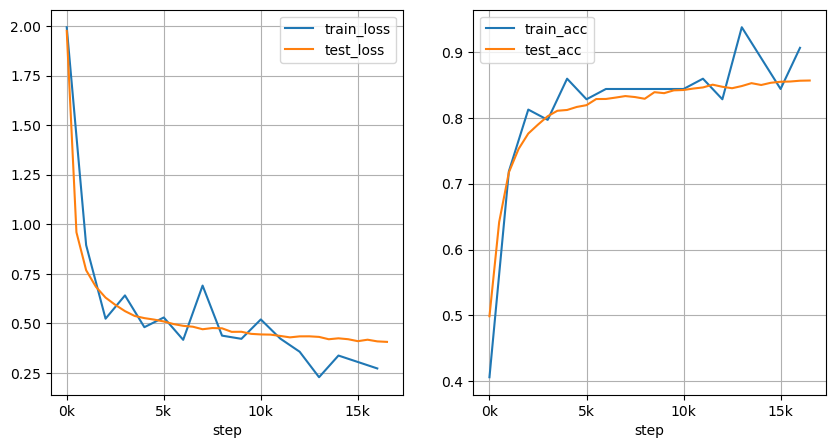

In [42]:
epoch = 20
save_ckpt_cb = SaveCheckpointCallback("checkpoints", save_best_only=True)
early_stop_cb = EarlyStopCallback(patience=10)
model = model.to(device)
record = training_early_stop(model, 
                             train_dataloader, 
                             test_dataloader, 
                             epoch, 
                             loss_function, 
                             optimizer_sgd, 
                             early_stop_cb=early_stop_cb,
                             save_ckpt_cb=save_ckpt_cb)

plot_learning_curve(record)

In [48]:
model.eval()
loss, acc = evaluating(model, test_dataloader, loss_function)
print("loss : {:.4f}, acc : {}".format(loss, acc))

loss : 0.4043, acc : 0.8566


In [53]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output : torch.Tensor = loss(input, target)
print(output)
output.backward()
print(output.item())

tensor(1.4894, grad_fn=<NllLossBackward0>)
1.4894218444824219
